In [1]:
# importing libraries
import pandas as pd
import numpy as np
from dataclasses import dataclass

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import skew
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score


from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading data
data_filename = "./installment2_id03.csv"
data_df = pd.read_csv(data_filename)
test_filename = "./installment2_evaluation_data.csv"
test_df = pd.read_csv(test_filename)

# Data Preprocessing

## Missing Value
There are no missing values here.

In [3]:
def df_summary(df):
    summary = []

    n_rows, n_cols = df.shape

    for col in df.columns:
        s = df[col]
        info = {
            "variable": col,
            "dtype": s.dtype,
            "n_missing": s.isna().sum(),
        }

        if pd.api.types.is_numeric_dtype(s):
            info.update({
                "min(for numerical variable)": s.min(),
                "max(for numerical variable)": s.max(),
                "n_unique": s.nunique(),
            })
        else:
            info.update({
                "n_unique": s.nunique(),
                "categories(for categorial variable)": s.dropna().unique()[:10],
            })

        summary.append(info)

    summary_df = pd.DataFrame(summary)

    return summary_df, n_rows, n_cols

summary_df, n_rows, n_cols = df_summary(data_df)
print(f"For training dataset, rows: {n_rows}, columns: {n_cols}")
display(summary_df)

For training dataset, rows: 2263, columns: 11


,variable,dtype,n_missing,min(for numerical variable),max(for numerical variable),n_unique,categories(for categorial variable)
0,PRSM,float64,0,-0.974979,2.976943e+00,2263,NaN
1,FICO,int64,0,482.000000,8.500000e+02,299,NaN
2,TotalAmtOwed,int64,0,10136.000000,1.791524e+06,2259,NaN
3,Volume,int64,0,2393.000000,8.284497e+06,2256,NaN
4,Stress,float64,0,0.004609,7.044360e-01,2263,NaN
5,Num_Delinquent,int64,0,3.000000,8.000000e+00,6,NaN
6,Num_CreditLines,int64,0,8.000000,1.300000e+01,6,NaN
7,WomanOwned,int64,0,0.000000,1.000000e+00,2,NaN
8,CorpStructure,object,0,NaN,NaN,4,"[LLC, Corp, Partner, Sole]"
9,NAICS,int64,0,441120.000000,7.225140e+05,21,NaN


## Outlier & Range Check

We check:
- **FICO** should be in [300, 850]. Values outside this range are data errors.
- **PRSM** should be ≥ 0.
- **Stress** is a ratio and should be non-negative.
- Any observation with extreme leverage could distort the regression.

**Outlier handling notes:**

- Remove records with negative `PRSM` values. 
- `TotalAmtOwed` and `Volume` have right-tailed outliers, but log-transformation will mitigate their leverage effect.

- FICO outside [300, 850]: 0 records
- PRSM < 0: 4 records
=== Negative PRSM records: ===


,PRSM,FICO,TotalAmtOwed,Volume,Stress,Num_Delinquent,Num_CreditLines,WomanOwned,CorpStructure,NAICS,Months
620,-0.813173,698,51311,13042,0.327857,4,10,1,Corp,459210,15
931,-0.974979,735,285143,260634,0.091170,4,12,0,Corp,722330,20
1513,-0.838569,688,377793,165021,0.190780,4,11,1,Sole,722330,18
1741,-0.023162,679,38315,16011,0.199420,4,9,0,Sole,445240,30


- Stress < 0: 0 records
- Num_Delinquent > Num_CreditLines: 0 records


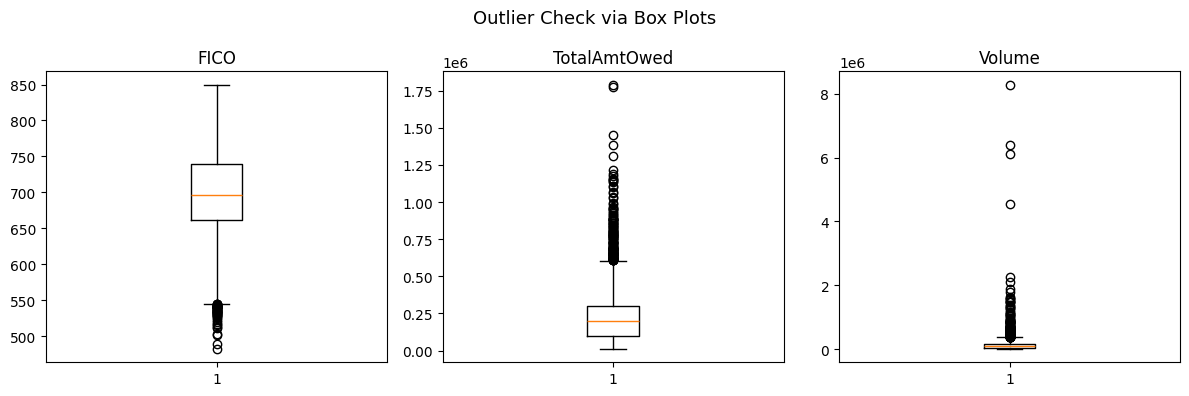

In [4]:
# FICO range
fico_out = data_df[(data_df['FICO'] < 300) | (data_df['FICO'] > 850)]
print(f"- FICO outside [300, 850]: {len(fico_out)} records")
if len(fico_out) > 0:
    display(fico_out)

# Negative PRSM
prsm_neg = data_df[data_df['PRSM'] < 0]
print(f"- PRSM < 0: {len(prsm_neg)} records")
if len(prsm_neg) > 0:
    print("=== Negative PRSM records: ===")
    display(prsm_neg)

# Negative Stress or other values that should be non-negative
stress_neg = data_df[data_df['Stress'] < 0]
print(f"- Stress < 0: {len(stress_neg)} records")

# Num_Delinquent greater than Num_CreditLines
num_delinq_gt_credit = data_df[data_df['Num_Delinquent'] > data_df['Num_CreditLines']]
print(f"- Num_Delinquent > Num_CreditLines: {len(num_delinq_gt_credit)} records")
if len(num_delinq_gt_credit) > 0:
    display(num_delinq_gt_credit)

# Box plots to visualize potential outliers in key numeric variables
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, var in enumerate(['FICO', 'TotalAmtOwed', 'Volume']):
    axes[i].boxplot(data_df[var], vert=True)
    axes[i].set_title(var)
plt.suptitle('Outlier Check via Box Plots', fontsize=13)
plt.tight_layout()
plt.show()

# Solution
data_df = data_df[data_df['PRSM'] >= 0]

## Feature Engineering

- By definition, we could intriduce `Prop_Delinquent_CreditLines` which should be helpful (`Num_Delinquent`/`Num_CreditLines`).
   Also, we could drop `Num_Delinquent` as its useful information is already contained in `Prop_Delinquent_CreditLines`.

- Categorize FICO for better explaination. The interpretation of a continuous score is usually "for every unit increase in the score, y changes by β", which is not intuitive in the context of credit scores while that of a discrete score is better: compared to the low-risk group, the y of the medium/high-risk group shows a systematic difference.

- We can use the first two digits in NAICS as the industry infomation.


In [5]:
# introduce Prop_Delinquent_CreditLines
data_df['Prop_Delinquent_Credit'] = data_df['Num_Delinquent'] / data_df['Num_CreditLines']
test_df['Prop_Delinquent_Credit'] = test_df['Num_Delinquent'] / test_df['Num_CreditLines']

# convert FICO to categorical risk categories
FICO_map = {
    0: (300, 579), # Poor
    1: (580, 669), # Fair
    2: (670, 739), # Good
    3: (740, 799), # Very Good
    4: (800, 850) # Excellent
}
data_df['FICO_category'] = data_df['FICO'].apply(lambda x: next((cat for cat, (low, high) in FICO_map.items() if low <= x <= high), np.nan))
test_df['FICO_category'] = test_df['FICO'].apply(lambda x: next((cat for cat, (low, high) in FICO_map.items() if low <= x <= high), np.nan))

# NAICS Industry Mapping Dictionary
naics_industry_map = {
    11: 'Agriculture, Forestry, Fishing and Hunting',
    21: 'Mining',
    22: 'Utilities',
    23: 'Construction',
    31: 'Manufacturing',
    32: 'Manufacturing',
    33: 'Manufacturing',
    42: 'Wholesale Trade',
    44: 'Retail Trade',
    45: 'Retail Trade',
    48: 'Transportation and Warehousing',
    49: 'Transportation and Warehousing',
    51: 'Information',
    52: 'Finance and Insurance',
    53: 'Real Estate Rental and Leasing',
    54: 'Professional, Scientific, and Technical Services',
    55: 'Management of Companies and Enterprises',
    56: 'Administrative and Support and Waste Management Services',
    61: 'Educational Services',
    62: 'Health Care and Social Assistance',
    71: 'Arts, Entertainment, and Recreation',
    72: 'Accommodation and Food Services',
    81: 'Other Services (except Public Administration)',
    92: 'Public Administration'
}

data_df['NAICS_2digit'] = (data_df['NAICS'] // 10000).astype(int)
data_df['NAICS_industry'] = data_df['NAICS_2digit'].map(naics_industry_map)

test_df['NAICS_2digit'] = (test_df['NAICS'] // 10000).astype(int)
test_df['NAICS_industry'] = test_df['NAICS_2digit'].map(naics_industry_map)

print("- NAICS Industry Mapping Summary (training dataset)")
print(f"Unique NAICS 2-digit codes: {sorted(data_df['NAICS_2digit'].unique())}")
print(f"Missing mappings: {data_df['NAICS_industry'].isna().sum()}")

print("- NAICS Industry Mapping Summary (test dataset)")
print(f"Unique NAICS 2-digit codes: {sorted(test_df['NAICS_2digit'].unique())}")
print(f"Missing mappings: {test_df['NAICS_industry'].isna().sum()}")

- NAICS Industry Mapping Summary (training dataset)
Unique NAICS 2-digit codes: [np.int64(44), np.int64(45), np.int64(72)]
Missing mappings: 0
- NAICS Industry Mapping Summary (test dataset)
Unique NAICS 2-digit codes: [np.int64(44), np.int64(45), np.int64(72)]
Missing mappings: 0


## Collinearity Check (VIF)

For multiple regression, multicollinearity inflates standard errors and makes coefficient interpretation unreliable. We use **Variance Inflation Factor (VIF)** to quantify it (VIF > 5~10 is a common threshold for concern). We only calculate VIF for numeric predictors that will enter the model as continuous variables.

**Collinearity observations:** Variables show low VIF, indicating no severe multicollinearity concern.

In [6]:
# Select numeric predictors only (exclude response PRSM, categorical/derived cols)
numeric_predictors = [
    'TotalAmtOwed',
    'Volume',
    'Stress',
    'Num_CreditLines',
    'Prop_Delinquent_Credit',
    'Months'
]

X_vif = data_df[numeric_predictors]
X_vif = X_vif.assign(const=1)  # VIF requires intercept

vif_df = pd.DataFrame({
    'Variable': numeric_predictors,
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(len(numeric_predictors))]
}).sort_values('VIF', ascending=False)

display(vif_df)

# Also show the Pearson correlation among the high-VIF suspects
print("\nPearson correlation among numeric predictors:")
display(data_df[numeric_predictors].corr().round(3))

,Variable,VIF
4,Prop_Delinquent_Credit,2.511157
3,Num_CreditLines,2.510489
1,Volume,1.357256
0,TotalAmtOwed,1.223197
2,Stress,1.150881
5,Months,1.001152



Pearson correlation among numeric predictors:


,TotalAmtOwed,Volume,Stress,Num_CreditLines,Prop_Delinquent_Credit,Months
TotalAmtOwed,1.000,0.392,0.031,-0.008,-0.024,0.012
Volume,0.392,1.000,-0.318,0.003,-0.015,0.004
Stress,0.031,-0.318,1.000,-0.025,0.022,0.028
Num_CreditLines,-0.008,0.003,-0.025,1.000,-0.775,-0.013
Prop_Delinquent_Credit,-0.024,-0.015,0.022,-0.775,1.000,0.007
Months,0.012,0.004,0.028,-0.013,0.007,1.000


## Variable Distribution & Transformation Check

For OLS regression, we want predictors with moderate spread and no extreme skew. Heavily right-skewed financial variables (e.g., `TotalAmtOwed`, `Volume`) often benefit from **log-transformation** because:
1. It reduces the influence of extreme values (large loans/volumes).
2. It converts multiplicative relationships to additive ones, which fits the linear model framework.
3. Coefficient interpretation becomes "a 1% increase in X is associated with a β/100 change in Y".

We check skewness of each numeric variable. For the response, we also need to verify whether its distribution is reasonably symmetric (important for residual normality).

**Transformation decisions:**

1. **`TotalAmtOwed`** and **`Volume`**: Both are financial magnitude variables with strong right skew. **Apply `log()` transform** — this makes the scale more manageable, reduces outlier influence, and converts the multiplicative nature of financial data to additive (suitable for linear regression).

2. **`Months`**: The README notes that "after a certain point, an additional month of operation has a diminished predictive effect." This could suggest a **concave** (log-like) relationship.

3. The rest of vars have moderate or low skewness and bounded ranges. **No transformation needed** at this stage.

,Variable,Skewness,Min,Max,Median,Mean
0,TotalAmtOwed,1.998180,10136.000000,1.791524e+06,196365.000000,238990.765826
1,Volume,13.882491,2393.000000,8.284497e+06,84414.000000,157069.588756
2,Stress,0.705741,0.004609,7.044360e-01,0.185512,0.198963
3,Num_CreditLines,0.025549,8.000000,1.300000e+01,10.000000,10.222665
4,Prop_Delinquent_Credit,0.847271,0.230769,1.000000e+00,0.400000,0.406247
5,Months,6.838923,5.000000,1.170000e+02,18.000000,18.209385


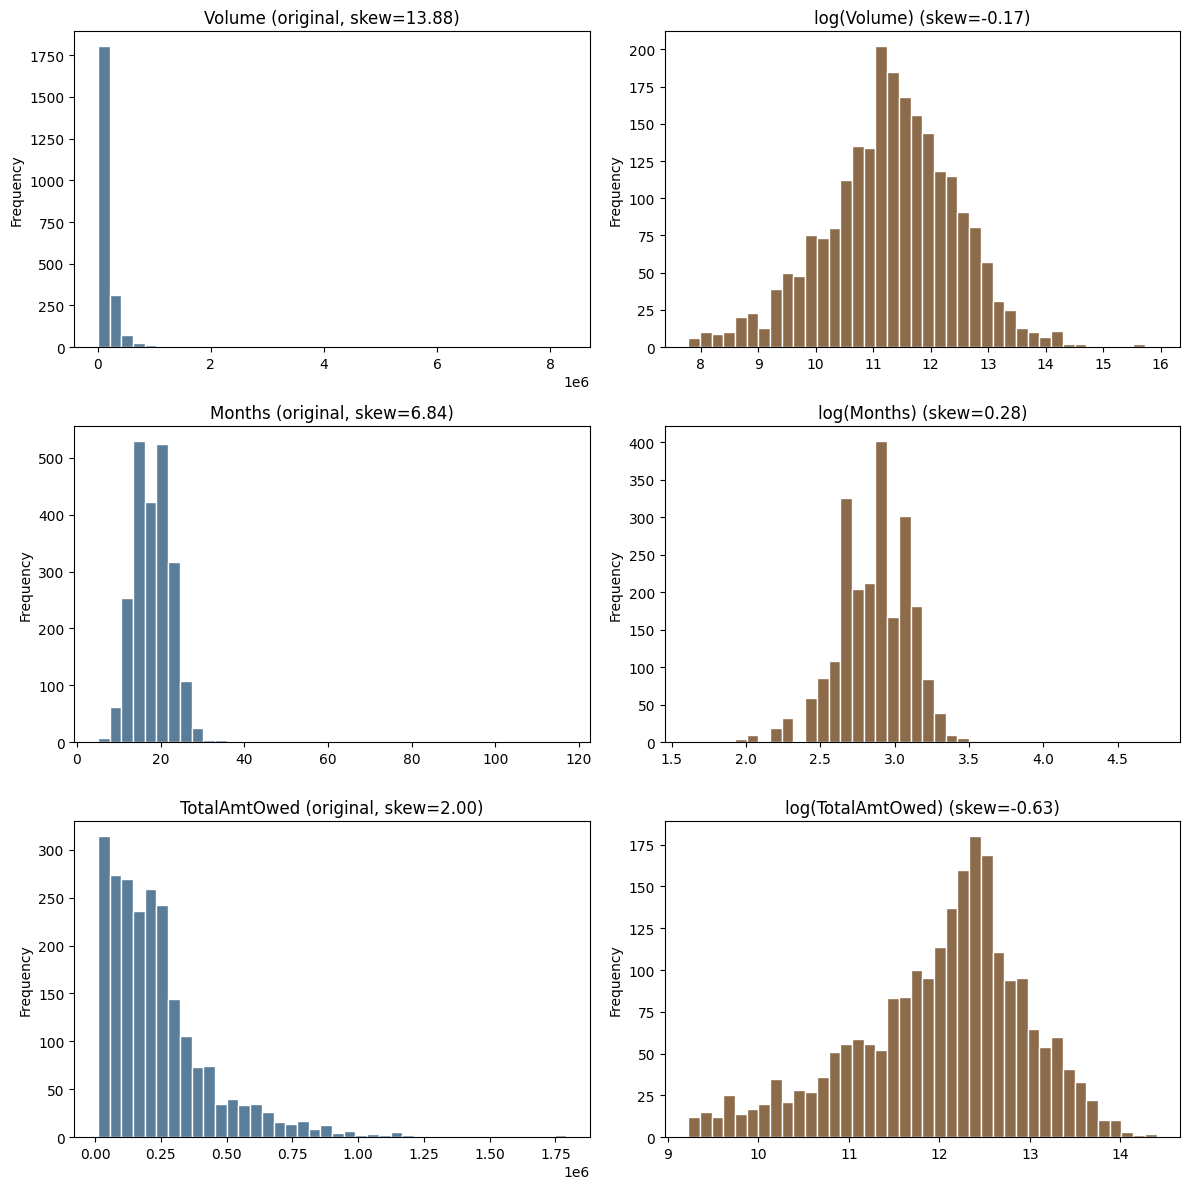

In [7]:
vars_to_check = ['TotalAmtOwed', 'Volume', 'Stress',
                 'Num_CreditLines', 'Prop_Delinquent_Credit', 'Months']

# Compute skewness
skew_df = pd.DataFrame({
    'Variable': vars_to_check,
    'Skewness': [skew(data_df[v]) for v in vars_to_check],
    'Min': [data_df[v].min() for v in vars_to_check],
    'Max': [data_df[v].max() for v in vars_to_check],
    'Median': [data_df[v].median() for v in vars_to_check],
    'Mean': [data_df[v].mean() for v in vars_to_check],
})
display(skew_df)

# Plot original vs log-transformed distributions for candidate variables
candidates_for_log = ['Volume', 'Months', 'TotalAmtOwed']  # financial vars likely to be right-skewed

fig, axes = plt.subplots(len(candidates_for_log), 2, figsize=(12, 4 * len(candidates_for_log)))
for i, var in enumerate(candidates_for_log):
    vals = data_df[var]
    vals_pos = vals[vals > 0]

    axes[i, 0].hist(vals, bins=40, color='#5A7D9A', edgecolor='white')
    axes[i, 0].set_title(f'{var} (original, skew={skew(vals):.2f})')
    axes[i, 0].set_ylabel('Frequency')

    axes[i, 1].hist(np.log(vals_pos), bins=40, color='#8C6B4A', edgecolor='white')
    axes[i, 1].set_title(f'log({var}) (skew={skew(np.log(vals_pos)):.2f})')
    axes[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# solution: log-transform for 'Volume', 'Months', 'TotalAmtOwed'
for var in candidates_for_log:
    data_df[f'log_{var}'] = np.log(data_df[var].where(data_df[var] > 0))
    test_df[f'log_{var}'] = np.log(test_df[var].where(test_df[var] > 0))

## Data Split 
Split the data into `train` and `dev` sets for model building and validation.

In [8]:
# Train/Dev split (80/20) with fixed random seed for reproducibility
train_df, dev_df = train_test_split(data_df, test_size=0.2, random_state=628)

print(f"Train set: {train_df.shape[0]} rows")
print(f"Dev set:   {dev_df.shape[0]} rows")
print(f"Test set (evaluation): {test_df.shape[0]} rows")

Train set: 1807 rows
Dev set:   452 rows
Test set (evaluation): 2500 rows


## PRSM Distribution
It's moderately skewed, so we keep it as-is for now. We will revisit after fitting the model (check residual diagnostics).

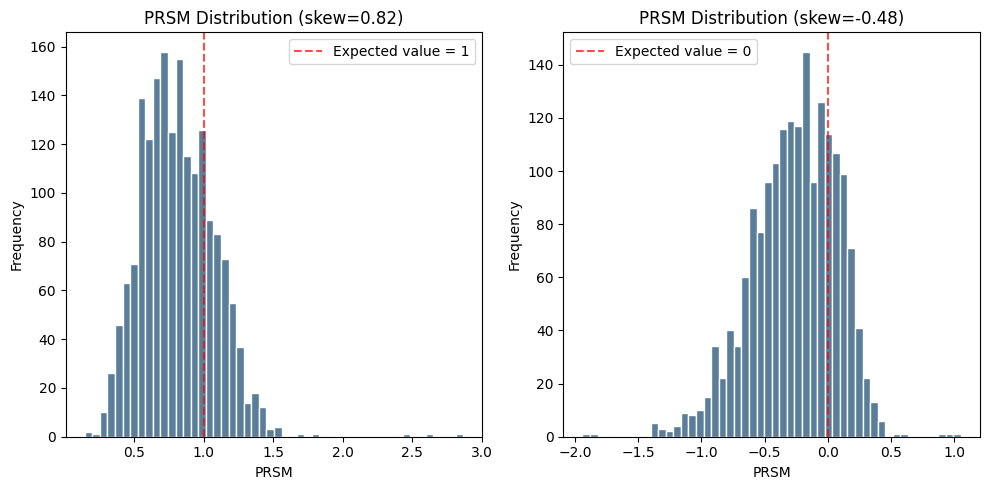

In [9]:
# Check PRSM (response) distribution — important for residual normality assumption
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].hist(train_df['PRSM'], bins=50, color='#5A7D9A', edgecolor='white')
axes[0].set_title(f'PRSM Distribution (skew={skew(train_df["PRSM"]):.2f})')
axes[0].set_xlabel('PRSM')
axes[0].set_ylabel('Frequency')
axes[0].axvline(x=1.0, color='red', linestyle='--', alpha=0.7, label='Expected value = 1')
axes[0].legend()


axes[1].hist(np.log(train_df['PRSM']), bins=50, color='#5A7D9A', edgecolor='white')
axes[1].set_title(f'PRSM Distribution (skew={skew(np.log(train_df["PRSM"])):.2f})')
axes[1].set_xlabel('PRSM')
axes[1].set_ylabel('Frequency')
axes[1].axvline(x=0.0, color='red', linestyle='--', alpha=0.7, label='Expected value = 0')
axes[1].legend()


plt.tight_layout()
plt.show()

## Categorical Variables vs PRSM

We examine how `CorpStructure`, `WomanOwned`, and `NAICS_industry` relate to PRSM. For the regression model, categorical variables will be encoded as dummy/indicator variables. We need to check:
- Whether different categories have meaningfully different PRSM distributions.
- Whether any categories have too few observations to be reliable.

**Categorical variable observations:**

- **`CorpStructure`**: The median PRSM differs across Corp, LLC, Partner, Sole. 
- **`WomanOwned`**: Women-owned businesses show different PRSM patterns.
- **`NAICS_industry`**: Almost the same across different industry. But this variable could be related with other varisbles, we can't drop it.
- We'll apply dummy vars for all of them.

Industry sample sizes:
NAICS_industry
Retail Trade                       1407
Accommodation and Food Services     400
Name: count, dtype: int64


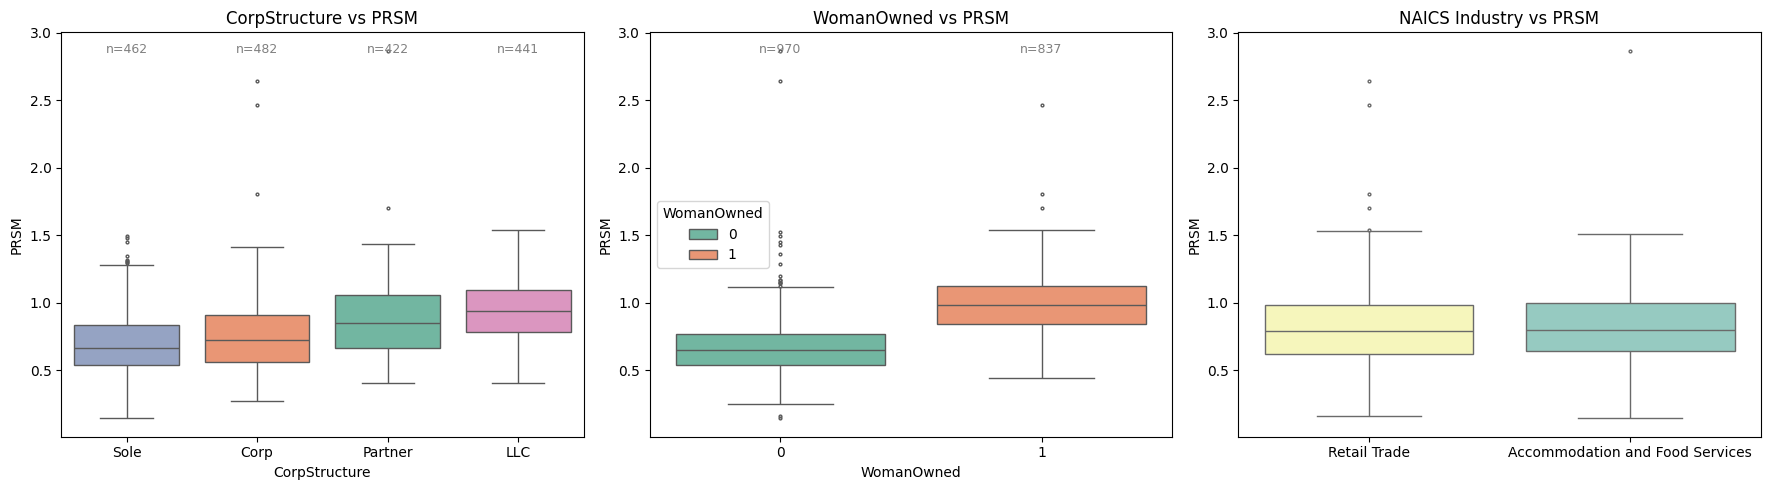

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. CorpStructure vs PRSM
order_corp = train_df.groupby('CorpStructure')['PRSM'].median().sort_values().index
sns.boxplot(data=train_df, x='CorpStructure', y='PRSM', order=order_corp, ax=axes[0],
            hue='CorpStructure', dodge=False, palette='Set2', fliersize=2)
axes[0].set_title('CorpStructure vs PRSM')
# annotate sample size
for i, cat in enumerate(order_corp):
    n = (train_df['CorpStructure'] == cat).sum()
    axes[0].text(i, axes[0].get_ylim()[1] * 0.95, f'n={n}', ha='center', fontsize=9, color='gray')

# 2. WomanOwned vs PRSM
sns.boxplot(data=train_df, x='WomanOwned', y='PRSM', ax=axes[1], hue='WomanOwned', dodge=False, palette='Set2', fliersize=2)
axes[1].set_title('WomanOwned vs PRSM')
for i, cat in enumerate([0, 1]):
    n = (train_df['WomanOwned'] == cat).sum()
    axes[1].text(i, axes[1].get_ylim()[1] * 0.95, f'n={n}', ha='center', fontsize=9, color='gray')

# 3. NAICS_industry vs PRSM (top industries by count)
top_industries = train_df['NAICS_industry'].value_counts()
print("Industry sample sizes:")
print(top_industries)
order_ind = train_df.groupby('NAICS_industry')['PRSM'].median().sort_values().index
sns.boxplot(data=train_df, x='NAICS_industry', y='PRSM', order=order_ind, ax=axes[2],
            hue='NAICS_industry', dodge=False, palette='Set3', fliersize=2)
axes[2].set_title('NAICS Industry vs PRSM')
axes[2].tick_params(axis='x', rotation=0)
axes[2].set_xlabel('')

plt.tight_layout()
plt.show()

# Solution: create dummy variables for CorpStructure and NAICS_industry and NAICS
train_df = pd.concat([train_df, pd.get_dummies(train_df['CorpStructure'], prefix='CorpStructure'), pd.get_dummies(train_df['NAICS_industry'], prefix='NAICS_ind'), pd.get_dummies(train_df['NAICS'], prefix='NAICS_code')], axis=1)
dev_df = pd.concat([dev_df, pd.get_dummies(dev_df['CorpStructure'], prefix='CorpStructure'), pd.get_dummies(dev_df['NAICS_industry'], prefix='NAICS_ind'), pd.get_dummies(dev_df['NAICS'], prefix='NAICS_code')], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['CorpStructure'], prefix='CorpStructure'), pd.get_dummies(test_df['NAICS_industry'], prefix='NAICS_ind'), pd.get_dummies(test_df['NAICS'], prefix='NAICS_code')], axis=1)


## Discrete Variable vs PRSM

We examine how `FICO_Category` relate to PRSM.

**Categorical variable observations:** PRSM differs across FICO categories. 

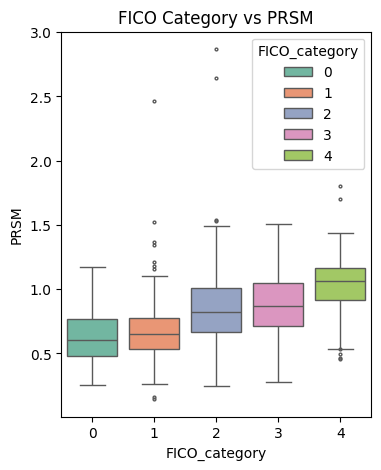

In [11]:
# FICO_category vs PRSM
fig, ax = plt.subplots(figsize=(4, 5))
order_fico = train_df.groupby('FICO_category')['PRSM'].median().sort_values().index
sns.boxplot(data=train_df, x='FICO_category', y='PRSM', order=order_fico, ax=ax,
            hue='FICO_category', dodge=False, palette='Set2', fliersize=2)
ax.set_title('FICO Category vs PRSM')
ax.tick_params(axis='x', rotation=0)


## Data Preparation Summary

### Variables entering the regression model

| Variable | Role | Transformation | Reason |
|---|---|---|---|
| `PRSM` | Response (y) | None | Revisit after residual check |
| `FICO_category` | Predictor | Discretization | Better explainability |
| `TotalAmtOwed`/`log(TotalAmtOwed)` | Predictor | log | Right-skewed financial variable; log reduces leverage of large values |
| `Volume`/`log(Volume)` | Predictor | log | Same reasoning as TotalAmtOwed |
| `Stress` | Predictor | None | Bounded ratio, moderate spread |
| `Num_CreditLines` | Predictor | None | Low skew, discrete |
| `Prop_Delinquent_Credit` | Predictor (new) | None | Ratio of delinquent / total credit lines — more informative than raw count |
| `Months`/`log(Months)` | Predictor | log | Diminishing marginal effect of business age |
| `WomanOwned` | Predictor | Indicator (0/1) | Binary, no transform needed |
| `CorpStructure` | Predictor | Dummy encoding | Categorical with 4 levels |
| `NAICS_industry` | Predictor | Dummy encoding (grouped) | Binary |

### Dropped variables
- `Num_Delinquent`: Its information is captured by `Prop_Delinquent_Credit`.
- `NAICS` (raw 6-digit): Replaced by `NAICS_industry` (2-digit industry grouping).
- `FICO`: Replaced by `FICO_category`.

### Observations removed
- Records with negative PRSM (data error).


# Save & Load Data

In [12]:
# Save for downstream modeling
train_df.to_csv('./train_df.csv', index=False)
dev_df.to_csv('./dev_df.csv', index=False)
test_df.to_csv('./test_df.csv', index=False)
print("\nSaved train_df.csv, dev_df.csv, and test_df.csv")

# Load data from EDA
train_df = pd.read_csv('./train_df.csv')
dev_df = pd.read_csv('./dev_df.csv')

print(f"Train set: {train_df.shape}")
print(f"Dev set:   {dev_df.shape}")
print(f"\nTrain columns: {train_df.columns.tolist()}")


Saved train_df.csv, dev_df.csv, and test_df.csv
Train set: (1807, 45)
Dev set:   (452, 45)

Train columns: ['PRSM', 'FICO', 'TotalAmtOwed', 'Volume', 'Stress', 'Num_Delinquent', 'Num_CreditLines', 'WomanOwned', 'CorpStructure', 'NAICS', 'Months', 'Prop_Delinquent_Credit', 'FICO_category', 'NAICS_2digit', 'NAICS_industry', 'log_Volume', 'log_Months', 'log_TotalAmtOwed', 'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner', 'CorpStructure_Sole', 'NAICS_ind_Accommodation and Food Services', 'NAICS_ind_Retail Trade', 'NAICS_code_441120', 'NAICS_code_444140', 'NAICS_code_444240', 'NAICS_code_445110', 'NAICS_code_445131', 'NAICS_code_445230', 'NAICS_code_445240', 'NAICS_code_445250', 'NAICS_code_445291', 'NAICS_code_445292', 'NAICS_code_445320', 'NAICS_code_458210', 'NAICS_code_458310', 'NAICS_code_459210', 'NAICS_code_459310', 'NAICS_code_459910', 'NAICS_code_722330', 'NAICS_code_722410', 'NAICS_code_722511', 'NAICS_code_722513', 'NAICS_code_722514']


# Python Utils for Models

In [13]:
# Utility Functions & Classes for Model Training and Evaluation
@dataclass
class ModelMetrics:
    """Store model evaluation metrics"""
    r2: float
    adj_r2: float
    rmse: float
    mae: float
    n_params: int
    model_name: str


def plot_residuals_diagnostics(residuals, fitted_values, model_name, color='lightblue', figsize=(8, 6)):
    """
    Plot 2x2 residual diagnostics: Residuals vs Fitted, Q-Q Plot, Distribution, Scale-Location

    Args:
        residuals: Residual values
        fitted_values: Fitted/predicted values
        model_name: Name for title
        color: Color for histogram
        figsize: Figure size
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # Residuals vs Fitted
    axes[0, 0].scatter(fitted_values, residuals, alpha=0.4, s=8)
    axes[0, 0].axhline(y=0, color='r', linestyle='--')
    axes[0, 0].set_xlabel('Fitted PRSMs')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title(f'{model_name}: Residuals vs Fitted')
    axes[0, 0].grid(alpha=0.3)

    # Q-Q Plot
    sm.qqplot(residuals, line='s', ax=axes[0, 1])
    axes[0, 1].set_title(f'{model_name}: Q-Q Plot')

    # Residuals Distribution
    axes[1, 0].hist(residuals, bins=40, color=color, edgecolor='black')
    axes[1, 0].set_xlabel('Residuals')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title(f'{model_name}: Residuals Distribution')

    # Scale-Location
    std_resid = residuals / residuals.std()
    axes[1, 1].scatter(fitted_values, np.sqrt(np.abs(std_resid)), alpha=0.4, s=8)
    axes[1, 1].set_xlabel('Fitted PRSMs')
    axes[1, 1].set_ylabel('Sqrt(|Standardized Residuals|)')
    axes[1, 1].set_title(f'{model_name}: Scale-Location')
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


def _quantile_pi(y_pred, residuals, alpha=0.05):
    """Build two-sided prediction interval using empirical residual quantile."""
    q = np.quantile(np.abs(np.asarray(residuals)), 1 - alpha)
    return y_pred - q, y_pred + q


def validate_on_dev_set(model, X_dev, y_dev, model_name, color='blue', model_type='OLS', train_residuals=None):
    """
    Validate model on development set and plot actual vs predicted with 95% prediction interval coverage.

    Args:
        model: Trained model (OLS or LASSO)
        X_dev: Dev set features
        y_dev: Dev set target
        model_name: Name for title
        color: Color for scatter plot
        model_type: 'OLS' or 'LASSO'
        train_residuals: Residuals used to estimate uncertainty

    Returns:
        Tuple of (RMSE, MAE, PI_Coverage)
    """
    y_pred = model.predict(X_dev)
    y_dev_arr = np.asarray(y_dev)

    rmse = np.sqrt(np.mean((y_dev_arr - y_pred)**2))
    mae = np.mean(np.abs(y_dev_arr - y_pred))

    # OLS: use model-based 95% PI if available; otherwise use empirical residual quantile
    if model_type == 'OLS' and hasattr(model, 'get_prediction'):
        try:
            predictions = model.get_prediction(X_dev)
            pred_summary = predictions.summary_frame(alpha=0.05)
            pi_lower = pred_summary['obs_ci_lower'].to_numpy()
            pi_upper = pred_summary['obs_ci_upper'].to_numpy()
            pi_method = 'OLS obs_ci'
        except Exception:
            residual_source = train_residuals if train_residuals is not None else getattr(model, 'resid', y_dev_arr - y_pred)
            pi_lower, pi_upper = _quantile_pi(y_pred, residual_source, alpha=0.05)
            pi_method = 'Residual quantile fallback'
    else:
        residual_source = train_residuals if train_residuals is not None else y_dev_arr - y_pred
        pi_lower, pi_upper = _quantile_pi(y_pred, residual_source, alpha=0.05)
        pi_method = 'Residual quantile'

    coverage = np.mean((y_dev_arr >= pi_lower) & (y_dev_arr <= pi_upper))

    print(f"\n=== {model_name} Dev Set Performance ===")
    print(f"RMSE = {rmse:.4f}")
    print(f"MAE = {mae:.4f}")
    print(f"95% Prediction Interval Coverage = {coverage:.4f} ({coverage*100:.2f}%)")
    print(f"PI method = {pi_method}")

    fig, ax = plt.subplots(figsize=(4, 3))
    ax.scatter(y_dev_arr, y_pred, alpha=0.4, s=8, color=color)
    ax.plot([y_dev_arr.min(), y_dev_arr.max()], [y_dev_arr.min(), y_dev_arr.max()], 'r--', lw=2, label='Perfect prediction')
    ax.set_xlabel('Actual PRSM (Dev)')
    ax.set_ylabel('Predicted PRSM')
    ax.set_title(f'{model_name}: Dev Actual vs Predicted\n(RMSE={rmse:.4f}, PI Coverage={coverage:.1%})')
    ax.legend()
    plt.tight_layout()
    plt.show()

    return rmse, mae, coverage


def fit_ols_model(X_train, y_train, model_name='OLS Model'):
    """
    Fit OLS model and return model + metrics.

    Args:
        X_train: Training features (with constant already added if needed)
        y_train: Training target
        model_name: Name for reporting

    Returns:
        Tuple of (model, metrics_dict)
    """
    if 'const' not in X_train.columns:
        X_train = sm.add_constant(X_train)

    model = sm.OLS(y_train, X_train).fit()

    r2 = model.rsquared
    adj_r2 = model.rsquared_adj
    n_params = int(model.df_model)

    print(f"\n=== {model_name} Metrics ===")
    print(f"R2 = {r2:.4f}")
    print(f"Adj R2 = {adj_r2:.4f}")

    return model, {'r2': r2, 'adj_r2': adj_r2, 'n_params': n_params}


def _cv_rmse(X, y, cv_splitter):
    model = LinearRegression()
    rmse_scores = -cross_val_score(
        model,
        X,
        y,
        scoring='neg_root_mean_squared_error',
        cv=cv_splitter,
    )
    return float(np.mean(rmse_scores))


def backward_stepwise_selection(X_train, y_train, threshold_p=0.05, cv=5, random_state=42, min_improvement=1e-4):
    """
    Backward feature selection driven by shuffled CV RMSE (not p-values).

    Args:
        X_train: Training features (with or without constant)
        y_train: Training target
        threshold_p: Unused, kept for backward compatibility
        cv: Number of CV folds
        random_state: Random seed for shuffled CV
        min_improvement: Minimum RMSE improvement required to keep removing features

    Returns:
        Tuple of (selected_predictors, final_model)
    """
    use_const = 'const' in X_train.columns
    predictors = [c for c in X_train.columns if c != 'const']

    if len(predictors) == 0:
        raise ValueError('No predictors available for stepwise selection.')

    cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    X_current = X_train[predictors]
    current_rmse = _cv_rmse(X_current, y_train, cv_splitter)

    print('Starting backward stepwise selection (criterion: CV RMSE)...')
    print(f'Initial predictors ({len(predictors)}): {predictors}')
    print(f'Initial CV RMSE: {current_rmse:.6f}\n')

    removed_features = []

    while len(predictors) > 1:
        candidate_results = []

        for feature in predictors:
            candidate_predictors = [p for p in predictors if p != feature]
            rmse_candidate = _cv_rmse(X_train[candidate_predictors], y_train, cv_splitter)
            candidate_results.append((feature, rmse_candidate))

        feature_to_remove, best_candidate_rmse = min(candidate_results, key=lambda x: x[1])

        if current_rmse - best_candidate_rmse > min_improvement:
            predictors.remove(feature_to_remove)
            removed_features.append((feature_to_remove, best_candidate_rmse))
            current_rmse = best_candidate_rmse
            print(f"Removing '{feature_to_remove}' -> CV RMSE: {current_rmse:.6f}")
        else:
            print('\nNo further meaningful CV RMSE improvement. Stopping.')
            break

    print(f"Final predictors ({len(predictors)}): {predictors}")
    if removed_features:
        print('Removed features:')
        for name, rmse in removed_features:
            print(f"  - {name} (best RMSE after removal: {rmse:.6f})")
    print()

    X_final = X_train[predictors].copy()
    if use_const:
        X_final = sm.add_constant(X_final, has_constant='add')

    final_model = sm.OLS(y_train, X_final).fit()
    return predictors, final_model


def fit_lasso_model(X_train, y_train, features_list, model_name='LASSO Model'):
    """
    Fit LASSO model with shuffled cross-validation for alpha selection.

    Args:
        X_train: Raw training features (will be standardized)
        y_train: Training target
        features_list: List of feature names
        model_name: Name for reporting

    Returns:
        Tuple of (lasso_model, scaler, metrics_dict)
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    print('Running LassoCV to find optimal alpha (shuffled CV)...')
    cv_splitter = KFold(n_splits=5, shuffle=True, random_state=42)
    lasso_cv = LassoCV(cv=cv_splitter, random_state=42, max_iter=10000, n_alphas=100)
    lasso_cv.fit(X_train_scaled, y_train)

    optimal_alpha = float(lasso_cv.alpha_)
    print(f'Optimal alpha selected: {optimal_alpha:.6f}')

    y_pred = lasso_cv.predict(X_train_scaled)
    r2 = r2_score(y_train, y_pred)
    n = len(y_train)
    p = int(np.sum(lasso_cv.coef_ != 0))

    if n - p - 1 > 0:
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    else:
        adj_r2 = np.nan

    print(f"\n=== {model_name} Metrics ===")
    print(f"R2 = {r2:.4f}")
    print(f"Adj R2 = {adj_r2:.4f}")
    print(f"Non-zero coefficients: {p} out of {len(features_list)}")

    lasso_coefs = pd.DataFrame({'Feature': features_list, 'Coefficient': lasso_cv.coef_})
    lasso_coefs['Abs_Coef'] = np.abs(lasso_coefs['Coefficient'])
    lasso_coefs = lasso_coefs.sort_values('Abs_Coef', ascending=False)

    print(f"\n=== {model_name} Selected Features ===")
    print(lasso_coefs[lasso_coefs['Coefficient'] != 0])

    removed = lasso_coefs[lasso_coefs['Coefficient'] == 0]['Feature'].tolist()
    if removed:
        print(f"\nRemoved features (zero coefficient): {removed}")

    residuals = np.asarray(y_train) - y_pred

    return lasso_cv, scaler, {
        'r2': r2,
        'adj_r2': adj_r2,
        'n_params': p,
        'optimal_alpha': optimal_alpha,
        'coefficients': lasso_coefs,
        'train_residuals': residuals,
    }


# Model
## Model 0: Baseline OLS

**Formula**: 
```
PRSM ~ FICO_category + TotalAmtOwed + Volume + Stress + Num_Delinquent + Num_CreditLines + Prop_Delinquent_Credit+ WomanOwned + Months + CorpStructure_Corp + CorpStructure_LLC + CorpStructure_Partner + NAICS_Retail Trade
```

**Rationale**: Establishes baseline without any log transformation.


=== Baseline OLS (with outlier) Metrics ===
R2 = 0.7431
Adj R2 = 0.7414


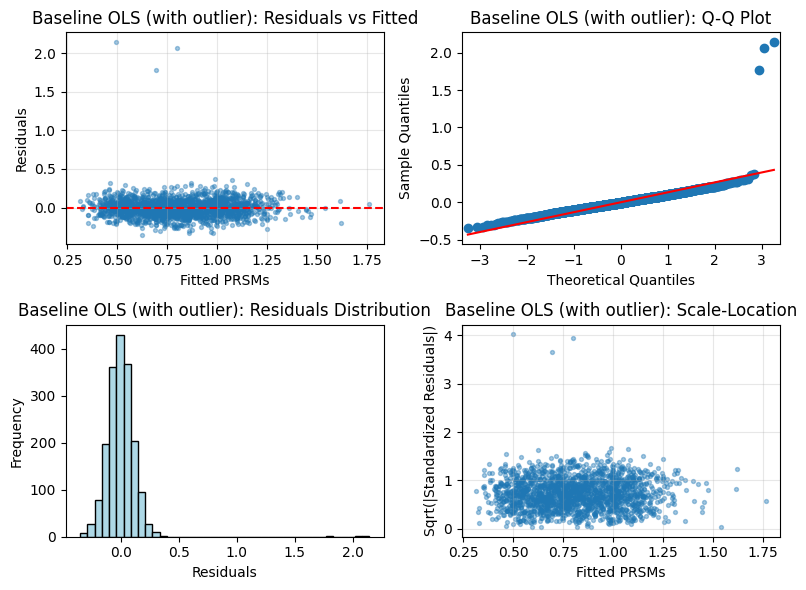

In [14]:
# Model 0: Baseline OLS
base_predictors = ['FICO_category', 'TotalAmtOwed', 'Volume', 'Stress', 'Num_CreditLines', 'Prop_Delinquent_Credit','WomanOwned', 'Months', 'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner', 'NAICS_ind_Retail Trade']

X_train_base = train_df[base_predictors].copy().astype(float)
X_train_base_with_const = sm.add_constant(X_train_base)
X_dev_base = dev_df[base_predictors].copy().astype(float)
X_dev_base_with_const = sm.add_constant(X_dev_base)
y_train = train_df['PRSM'].astype(float)
y_dev = dev_df['PRSM'].astype(float)

# Train model using utility function
model_baselineOLS, metrics_baselineOLS = fit_ols_model(X_train_base_with_const, y_train, 'Baseline OLS (with outlier)')

# Store metrics for comparison
baselineOLS_r2 = metrics_baselineOLS['r2']
baselineOLS_adj_r2 = metrics_baselineOLS['adj_r2']

# Model 0: Residual diagnostics
residuals_baselineOLS = model_baselineOLS.resid
fitted_baselineOLS = model_baselineOLS.fittedvalues
plot_residuals_diagnostics(residuals_baselineOLS, fitted_baselineOLS, 'Baseline OLS (with outlier)', color='lightblue')

Outliers in the Residuals-FittedValues plot! Let's remove them.

Outlier Samples (|residuals| > 0.5):
Number of outliers: 3
Outlier indices: [49, 866, 1152]

Outlier Sample Details:
   Index  Actual_PRSM  Predicted_PRSM  Residual  Abs_Residual
0     49     2.640174        0.496746  2.143429      2.143429
1    866     2.867347        0.798133  2.069214      2.069214
2   1152     2.467309        0.693143  1.774166      1.774166

Original training set size: 1807
Removed 3 outlier samples
New training set size: 1804


=== Baseline Model Metrics ===
R2 = 0.8264
Adj R2 = 0.8253


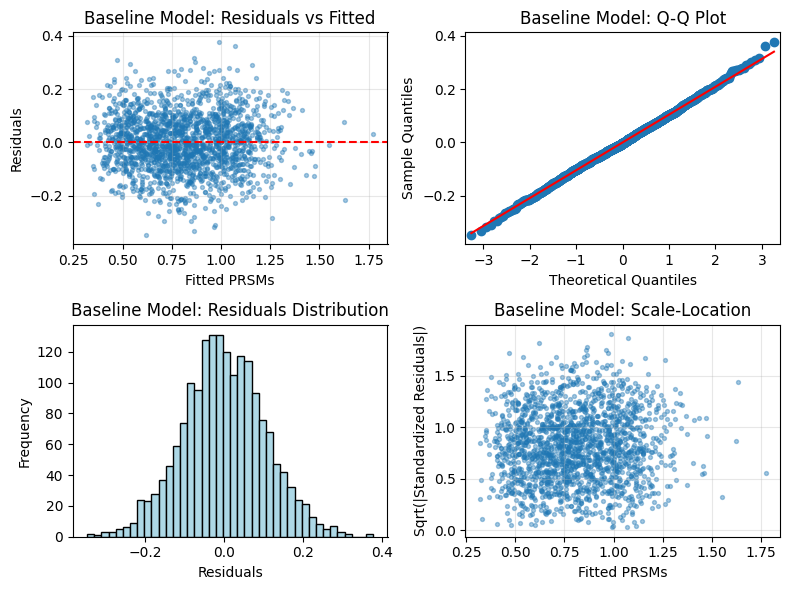


=== Baseline Model Dev Set Performance ===
RMSE = 0.2168
MAE = 0.1029
95% Prediction Interval Coverage = 0.9491 (94.91%)
PI method = OLS obs_ci


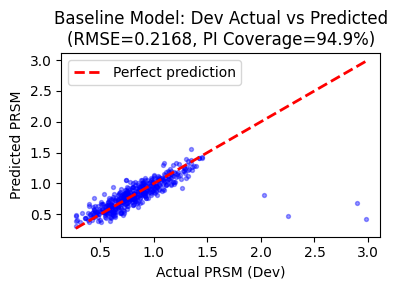

In [15]:
# Model 0: Identify outlier samples (residuals > 0.5)
outlier_threshold = 0.5
abs_residuals = np.abs(residuals_baselineOLS)
outlier_mask = abs_residuals > outlier_threshold
outlier_indices = np.where(outlier_mask)[0]

print(f"Outlier Samples (|residuals| > {outlier_threshold}):")
print(f"Number of outliers: {len(outlier_indices)}")
print(f"Outlier indices: {outlier_indices.tolist()}\n")

# Display details of outlier samples
if len(outlier_indices) > 0:
    outlier_data = pd.DataFrame({
        'Index': outlier_indices,
        'Actual_PRSM': y_train.iloc[outlier_indices].values,
        'Predicted_PRSM': fitted_baselineOLS.iloc[outlier_indices].values,
        'Residual': residuals_baselineOLS.iloc[outlier_indices].values,
        'Abs_Residual': abs_residuals.iloc[outlier_indices].values
    })
    print("Outlier Sample Details:")
    print(outlier_data.to_string())
    print()
    
else:
    print("No outliers found!")


# Model 0.5: OLS with Outliers Removed
# Create training data without outliers
inlier_mask = (~outlier_mask).values  # Convert Series to numpy boolean array
X_train_base_del = X_train_base[inlier_mask].copy().astype(float)
X_train_base_with_const_del = sm.add_constant(X_train_base_del)
y_train_base_del = y_train[inlier_mask].copy().astype(float)

print(f"Original training set size: {len(X_train_base)}")
print(f"Removed {len(outlier_indices)} outlier samples")
print(f"New training set size: {len(X_train_base_del)}\n")

# Train OLS model without outliers
model_baselineOLS_del, metrics_baselineOLS_del = fit_ols_model(X_train_base_with_const_del, y_train_base_del, 'Baseline Model')

# Store metrics for comparison
baselineOLS_del_r2 = metrics_baselineOLS_del['r2']
baselineOLS_del_adj_r2 = metrics_baselineOLS_del['adj_r2']

# Model 0.5: Residual diagnostics
residuals_baselineOLS_del = model_baselineOLS_del.resid
fitted_baselineOLS_del = model_baselineOLS_del.fittedvalues
plot_residuals_diagnostics(residuals_baselineOLS_del, fitted_baselineOLS_del, 'Baseline Model', color='lightblue')

# Model 0.5: Dev set validation
rmse_baselineOLS_del, mae_baselineOLS_del, coverage_baselineOLS_del = validate_on_dev_set(
    model_baselineOLS_del, X_dev_base_with_const, y_dev, 'Baseline Model', 'blue', model_type='OLS')


## Model 1: LASSO Regression for baseline OLS

**Rationale**: Penalized regression that automatically performs variable selection and shrinkage.
- LASSO adds L1 penalty: minimizes $\sum (y_i - \hat{y}_i)^2 + \alpha \sum |\beta_j|$
- Forces some coefficients exactly to zero → automatic feature selection
- Uses cross-validation to select optimal $\alpha$ (regularization strength)
- **Benefits**: Handles multicollinearity; produces sparse models; prevents overfitting

**Method**: LassoCV with 5-fold cross-validation to select best $\alpha$

Running LassoCV to find optimal alpha (shuffled CV)...
Optimal alpha selected: 0.000530

=== Baseline LASSO Metrics ===
R2 = 0.8263
Adj R2 = 0.8252
Non-zero coefficients: 12 out of 12

=== Baseline LASSO Selected Features ===
                   Feature  Coefficient  Abs_Coef
6               WomanOwned     0.138977  0.138977
9        CorpStructure_LLC     0.104249  0.104249
1             TotalAmtOwed     0.100488  0.100488
10   CorpStructure_Partner     0.072586  0.072586
0            FICO_category     0.053800  0.053800
3                   Stress     0.050208  0.050208
7                   Months     0.012864  0.012864
8       CorpStructure_Corp     0.012438  0.012438
2                   Volume    -0.002587  0.002587
11  NAICS_ind_Retail Trade    -0.001967  0.001967
5   Prop_Delinquent_Credit    -0.001201  0.001201
4          Num_CreditLines     0.000010  0.000010


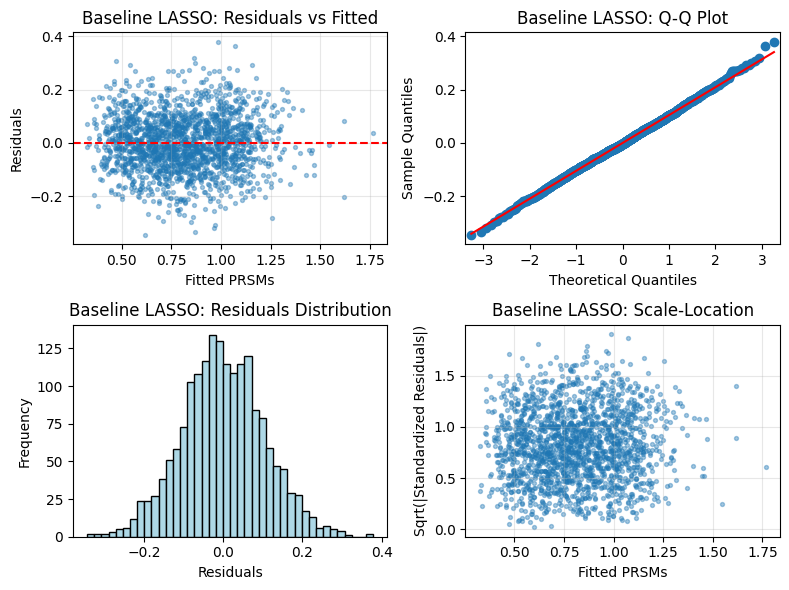


=== Baseline LASSO Dev Set Performance ===
RMSE = 0.2166
MAE = 0.1029
95% Prediction Interval Coverage = 0.9513 (95.13%)
PI method = Residual quantile


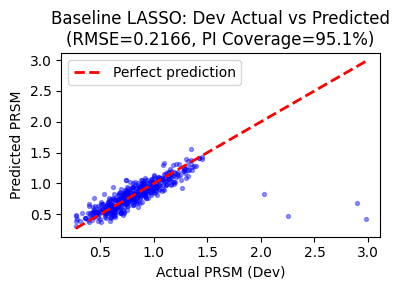

In [16]:
# Model 1: LASSO Regression with Cross-Validation
# Fit LASSO using utility function
model_baselineLASSO, scaler_baselineLASSO, metrics_baselineLASSO = fit_lasso_model(
    X_train_base_del, y_train_base_del, base_predictors, 'Baseline LASSO'
)

# Store metrics
baselineLASSO_r2 = metrics_baselineLASSO['r2']
baselineLASSO_adj_r2 = metrics_baselineLASSO['adj_r2']
lasso_coefs_baselineLASSO = metrics_baselineLASSO['coefficients']

# Prepare data for residual diagnostics
X_train_lasso_scaled = scaler_baselineLASSO.transform(X_train_base_del)
y_pred_train_baselineLASSO = model_baselineLASSO.predict(X_train_lasso_scaled)

# Model 1: Residual diagnostics
residuals_baselineLASSO = y_train_base_del - y_pred_train_baselineLASSO
fitted_baselineLASSO = y_pred_train_baselineLASSO
plot_residuals_diagnostics(residuals_baselineLASSO, fitted_baselineLASSO, 'Baseline LASSO', color='lightblue')

# Model 1: Dev set validation
X_dev_lasso_scaled = scaler_baselineLASSO.transform(X_dev_base)
rmse_baselineLASSO, mae_baselineLASSO, coverage_baselineLASSO = validate_on_dev_set(
    model_baselineLASSO, X_dev_lasso_scaled, y_dev, 'Baseline LASSO', 'blue', 
    model_type='LASSO', train_residuals=metrics_baselineLASSO['train_residuals'])

## Model 2: Backward Stepwise OLS for baseline OLS

**Rationale**: Automatically select the most important predictors by iteratively removing features with high p-values.
- Starts with all predictors from Model 0
- Removes features with p-value > 0.05 one at a time (highest p-value first)
- Stops when all remaining features are significant or when AIC stops improving
- **Benefits**: Improved interpretability by removing weak predictors; reduces overfitting

**Method**: Backward stepwise selection based on p-values and AIC

Starting backward stepwise selection (criterion: CV RMSE)...
Initial predictors (12): ['FICO_category', 'TotalAmtOwed', 'Volume', 'Stress', 'Num_CreditLines', 'Prop_Delinquent_Credit', 'WomanOwned', 'Months', 'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner', 'NAICS_ind_Retail Trade']
Initial CV RMSE: 0.105245


No further meaningful CV RMSE improvement. Stopping.
Final predictors (12): ['FICO_category', 'TotalAmtOwed', 'Volume', 'Stress', 'Num_CreditLines', 'Prop_Delinquent_Credit', 'WomanOwned', 'Months', 'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner', 'NAICS_ind_Retail Trade']

                            OLS Regression Results                            
Dep. Variable:                   PRSM   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     710.6
Date:                Tue, 17 Feb 2026   Prob (F-statistic):

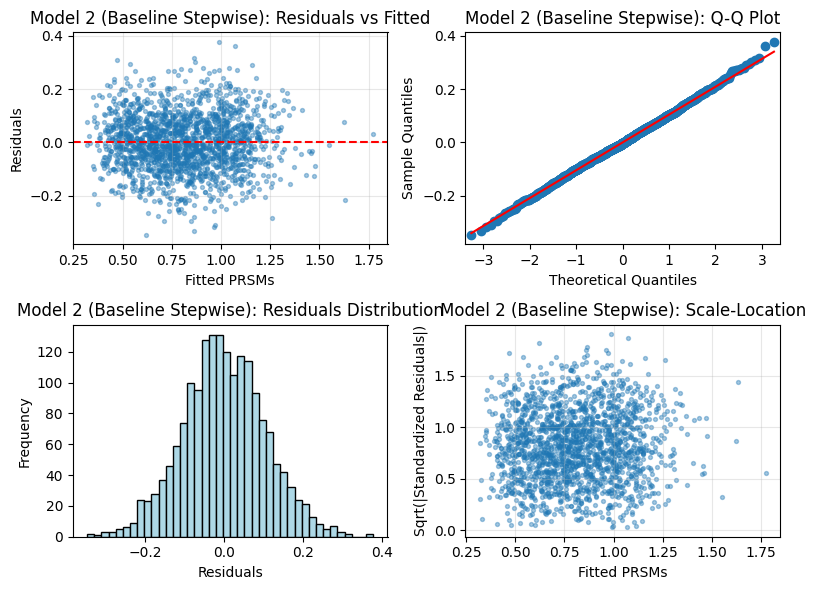


=== Model 2: Baseline Stepwise OLS Dev Set Performance ===
RMSE = 0.2168
MAE = 0.1029
95% Prediction Interval Coverage = 0.9491 (94.91%)
PI method = OLS obs_ci


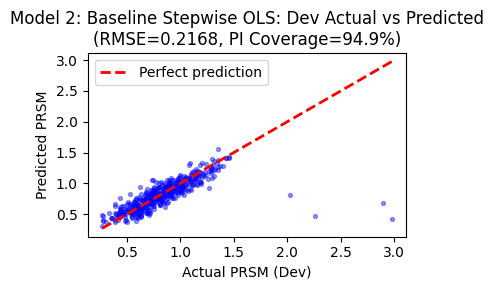

In [17]:
# Model 2: Backward Stepwise OLS (Baseline Predictors)

# Perform backward stepwise selection using utility function
stepwise_predictors_baselineStep, model_baselineStep = backward_stepwise_selection(X_train_base_with_const_del, y_train_base_del, threshold_p=0.05)

# Print model summary
print("=" * 80)
print(model_baselineStep.summary())

# Store metrics
baselineStep_r2 = model_baselineStep.rsquared
baselineStep_adj_r2 = model_baselineStep.rsquared_adj
print(f"\n=== Model 2 (Baseline Stepwise) Metrics ===")
print(f"R² = {baselineStep_r2:.4f}")
print(f"Adj R² = {baselineStep_adj_r2:.4f}")

# Model 2: Residual diagnostics
residuals_baselineStep = model_baselineStep.resid
fitted_baselineStep = model_baselineStep.fittedvalues
plot_residuals_diagnostics(residuals_baselineStep, fitted_baselineStep, 'Model 2 (Baseline Stepwise)', color='lightblue')

# Model 2: Dev set validation
X_dev_baselineStep = dev_df[stepwise_predictors_baselineStep].copy().astype(float)
X_dev_baselineStep = sm.add_constant(X_dev_baselineStep)

rmse_baselineStep, mae_baselineStep, coverage_baselineStep = validate_on_dev_set(
    model_baselineStep, X_dev_baselineStep, y_dev, 'Model 2: Baseline Stepwise OLS', 'blue', model_type='OLS')


## Model 3: OLS with preprocessed predictors

**Formula**: 
```
PRSM ~ FICO_category + log_TotalAmtOwed + log_Volume + Stress + log_Months + 
        Num_CreditLines + Prop_Delinquent_Credit  + WomanOwned + 
       CorpStructure_Corp + CorpStructure_LLC + CorpStructure_Partner + NAICS_Retail Trade
```

**Rationale**: Using variables with log-transformation, simple linear relationships.


=== Model 3: Prep OLS Metrics ===
R2 = 0.7004
Adj R2 = 0.6984
                            OLS Regression Results                            
Dep. Variable:                   PRSM   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     349.6
Date:                Tue, 17 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:18:54   Log-Likelihood:                 947.47
No. Observations:                1807   AIC:                            -1869.
Df Residuals:                    1794   BIC:                            -1797.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

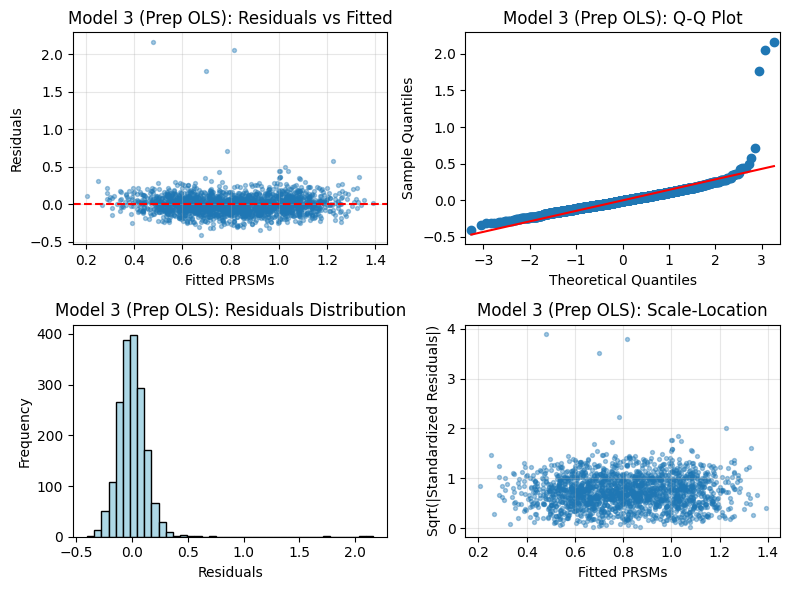

In [18]:
# Model 3: OLS with Preprocessed Variables
preprocessed_predictors = ['FICO_category', 'log_TotalAmtOwed', 'log_Volume', 'Stress', 'log_Months',
                   'Num_CreditLines', 'Prop_Delinquent_Credit', 'WomanOwned',
                   'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner',
                   'NAICS_ind_Retail Trade']

X_train_preprocessed = train_df[preprocessed_predictors].copy().astype(float)
X_train_preprocessed_with_const = sm.add_constant(X_train_preprocessed)
X_dev_preprocessed = dev_df[preprocessed_predictors].copy().astype(float)
X_dev_preprocessed_with_const = sm.add_constant(X_dev_preprocessed)

# Train model using utility function
model_preOLS, metrics_preOLS = fit_ols_model(X_train_preprocessed_with_const, y_train, 'Model 3: Prep OLS')
print(model_preOLS.summary())

# Store metrics
preOLS_r2 = metrics_preOLS['r2']
preOLS_adj_r2 = metrics_preOLS['adj_r2']

# Model 3: Residual diagnostics
residuals_preOLS = model_preOLS.resid
fitted_preOLS = model_preOLS.fittedvalues
plot_residuals_diagnostics(residuals_preOLS, fitted_preOLS, 'Model 3 (Prep OLS)', color='lightblue')

Outlier Samples (|residuals| > 0.5):
Number of outliers: 5
Outlier indices: [49, 134, 866, 952, 1152]

Outlier Sample Details:
   Index  Actual_PRSM  Predicted_PRSM  Residual  Abs_Residual
0     49     2.640174        0.479060  2.161114      2.161114
1    134     1.805559        1.225207  0.580352      0.580352
2    866     2.867347        0.815887  2.051460      2.051460
3    952     1.495186        0.784426  0.710760      0.710760
4   1152     2.467309        0.699310  1.767999      1.767999

Original training set size: 1807
Removed 5 outlier samples
New training set size: 1802


=== Model 3 Preprocessed OLS Metrics ===
R2 = 0.7843
Adj R2 = 0.7829


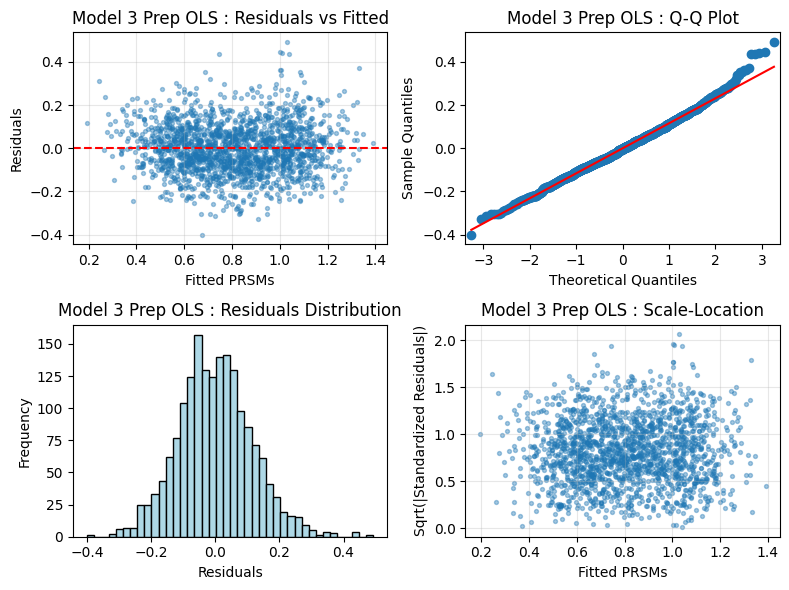


=== Model 3 Prep OLS  Dev Set Performance ===
RMSE = 0.2224
MAE = 0.1115
95% Prediction Interval Coverage = 0.9381 (93.81%)
PI method = OLS obs_ci


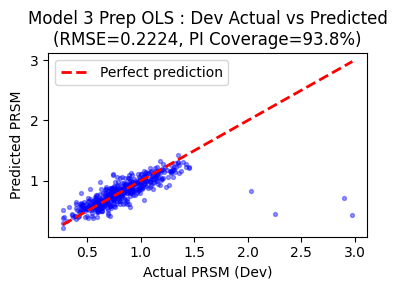

In [19]:
# Model 3: Identify outlier samples (residuals > 0.5)
outlier_pre_threshold = 0.5
abs_residuals = np.abs(residuals_preOLS)
outlier_mask = abs_residuals > outlier_pre_threshold
outlier_indices = np.where(outlier_mask)[0]

print(f"Outlier Samples (|residuals| > {outlier_pre_threshold}):")
print(f"Number of outliers: {len(outlier_indices)}")
print(f"Outlier indices: {outlier_indices.tolist()}\n")

# Display details of outlier samples
if len(outlier_indices) > 0:
    outlier_data = pd.DataFrame({
        'Index': outlier_indices,
        'Actual_PRSM': y_train.iloc[outlier_indices].values,
        'Predicted_PRSM': fitted_preOLS.iloc[outlier_indices].values,
        'Residual': residuals_preOLS.iloc[outlier_indices].values,
        'Abs_Residual': abs_residuals.iloc[outlier_indices].values
    })
    print("Outlier Sample Details:")
    print(outlier_data.to_string())
    print()
    
else:
    print("No outliers found!")


# Model 3.5: OLS with Outliers Removed
# Create training data without outliers
inlier_mask = (~outlier_mask).values  # Convert Series to numpy boolean array
X_train_preprocessed_del = X_train_preprocessed[inlier_mask].copy().astype(float)
X_train_preprocessed_with_const_del = sm.add_constant(X_train_preprocessed_del)
y_train_preprocessed_del = y_train[inlier_mask].copy().astype(float)

print(f"Original training set size: {len(X_train_preprocessed)}")
print(f"Removed {len(outlier_indices)} outlier samples")
print(f"New training set size: {len(X_train_preprocessed_del)}\n")

# Train OLS model without outliers
model_preOLS_del, metrics_preOLS_del = fit_ols_model(X_train_preprocessed_with_const_del, y_train_preprocessed_del, 'Model 3 Preprocessed OLS')

# Store metrics for comparison
preOLS_del_r2 = metrics_preOLS_del['r2']
preOLS_del_adj_r2 = metrics_preOLS_del['adj_r2']

# Model 3.5: Residual diagnostics
residuals_preOLS_del = model_preOLS_del.resid
fitted_preOLS_del = model_preOLS_del.fittedvalues
plot_residuals_diagnostics(residuals_preOLS_del, fitted_preOLS_del, 'Model 3 Prep OLS ', color='lightblue')

# Model 3.5: Dev set validation
rmse_preOLS_del, mae_preOLS_del, coverage_preOLS_del = validate_on_dev_set(
    model_preOLS_del, X_dev_preprocessed_with_const, y_dev, 'Model 3 Prep OLS ', 'blue', model_type='OLS')


## Model 4: Backward Stepwise OLS for preprocessed OLS

Starting backward stepwise selection (criterion: CV RMSE)...
Initial predictors (12): ['FICO_category', 'log_TotalAmtOwed', 'log_Volume', 'Stress', 'log_Months', 'Num_CreditLines', 'Prop_Delinquent_Credit', 'WomanOwned', 'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner', 'NAICS_ind_Retail Trade']
Initial CV RMSE: 0.116742


No further meaningful CV RMSE improvement. Stopping.
Final predictors (12): ['FICO_category', 'log_TotalAmtOwed', 'log_Volume', 'Stress', 'log_Months', 'Num_CreditLines', 'Prop_Delinquent_Credit', 'WomanOwned', 'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner', 'NAICS_ind_Retail Trade']

                            OLS Regression Results                            
Dep. Variable:                   PRSM   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     542.2
Date:                Tue, 17 Feb 20

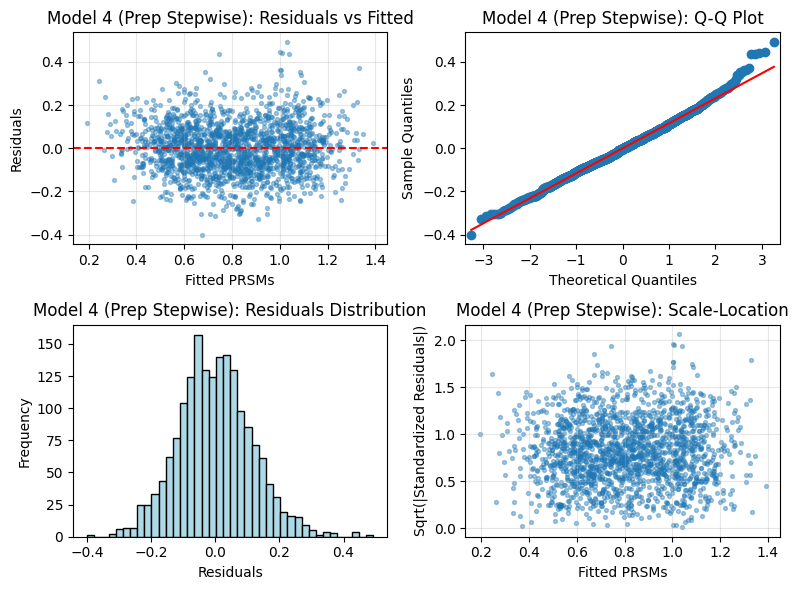


=== Model 4: Prep Stepwise OLS Dev Set Performance ===
RMSE = 0.2224
MAE = 0.1115
95% Prediction Interval Coverage = 0.9381 (93.81%)
PI method = OLS obs_ci


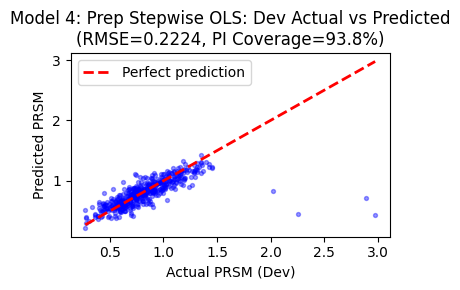

In [20]:
# Model 4: Backward Stepwise OLS (Preprocessed Predictors)

# Perform backward stepwise selection using utility function
stepwise_predictors_preStep, model_preStep = backward_stepwise_selection(X_train_preprocessed_with_const_del, y_train_preprocessed_del, threshold_p=0.05)

# Print model summary
print("=" * 80)
print(model_preStep.summary())

# Store metrics
preStep_r2 = model_preStep.rsquared
preStep_adj_r2 = model_preStep.rsquared_adj
print(f"\n=== Model 4 (Prep Stepwise) Metrics ===")
print(f"R² = {preStep_r2:.4f}")
print(f"Adj R² = {preStep_adj_r2:.4f}")

# Model 4: Residual diagnostics
residuals_preStep = model_preStep.resid
fitted_preStep = model_preStep.fittedvalues
plot_residuals_diagnostics(residuals_preStep, fitted_preStep, 'Model 4 (Prep Stepwise)', color='lightblue')

# Model 4: Dev set validation
X_dev_preStep = dev_df[stepwise_predictors_preStep].copy().astype(float)
X_dev_preStep = sm.add_constant(X_dev_preStep)

rmse_preStep, mae_preStep, coverage_preStep = validate_on_dev_set(
    model_preStep, X_dev_preStep, y_dev, 'Model 4: Prep Stepwise OLS', 'blue', model_type='OLS')


## Model 5: LASSO Regression for preprocessed OLS

Running LassoCV to find optimal alpha (shuffled CV)...
Optimal alpha selected: 0.000186

=== Model 5: LASSO (Preprocessed) Metrics ===
R2 = 0.7843
Adj R2 = 0.7829
Non-zero coefficients: 12 out of 12

=== Model 5: LASSO (Preprocessed) Selected Features ===
                   Feature  Coefficient  Abs_Coef
7               WomanOwned     0.138645  0.138645
9        CorpStructure_LLC     0.104768  0.104768
1         log_TotalAmtOwed     0.094711  0.094711
10   CorpStructure_Partner     0.071483  0.071483
0            FICO_category     0.055241  0.055241
3                   Stress     0.043694  0.043694
4               log_Months     0.019902  0.019902
2               log_Volume    -0.016561  0.016561
8       CorpStructure_Corp     0.014188  0.014188
11  NAICS_ind_Retail Trade    -0.001580  0.001580
6   Prop_Delinquent_Credit    -0.001303  0.001303
5          Num_CreditLines    -0.000316  0.000316


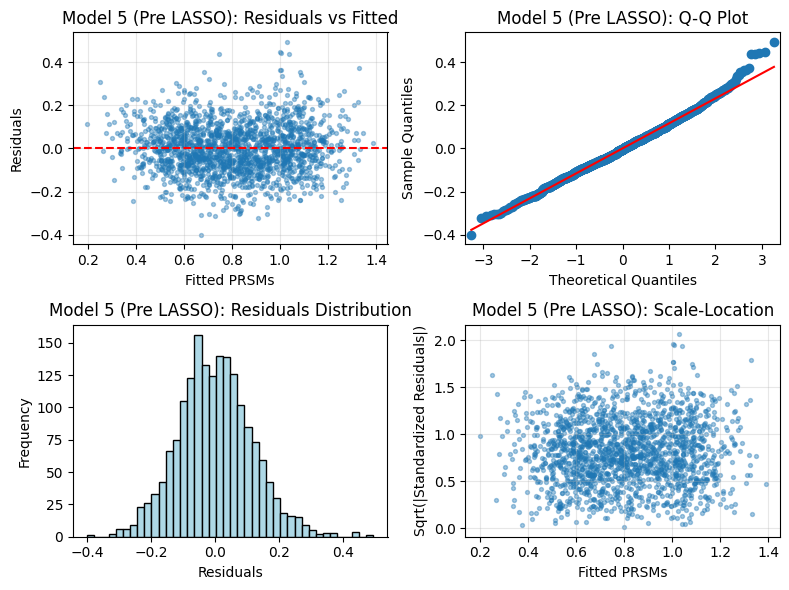


=== Model 5: Prep LASSO Dev Set Performance ===
RMSE = 0.2224
MAE = 0.1116
95% Prediction Interval Coverage = 0.9381 (93.81%)
PI method = Residual quantile


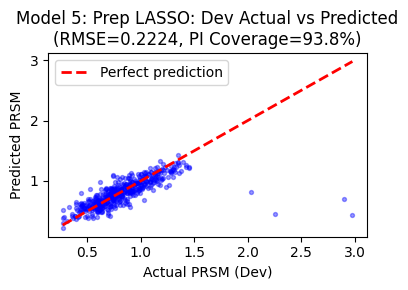

In [21]:
# Model 5: LASSO Regression (Preprocessed Predictors)

# Fit LASSO using utility function
model_preLASSO, scaler_preLASSO, metrics_preLASSO = fit_lasso_model(
    X_train_preprocessed_del, y_train_preprocessed_del, preprocessed_predictors, 'Model 5: LASSO (Preprocessed)'
)

# Store metrics
preLASSO_r2 = metrics_preLASSO['r2']
preLASSO_adj_r2 = metrics_preLASSO['adj_r2']
lasso_coefs_preLASSO = metrics_preLASSO['coefficients']

# Prepare data for residual diagnostics
X_train_preLASSO_scaled = scaler_preLASSO.transform(X_train_preprocessed_del)
y_pred_train_preLASSO = model_preLASSO.predict(X_train_preLASSO_scaled)

# Model 5: Residual diagnostics
residuals_preLASSO = y_train_preprocessed_del - y_pred_train_preLASSO
fitted_preLASSO = y_pred_train_preLASSO
plot_residuals_diagnostics(residuals_preLASSO, fitted_preLASSO, 'Model 5 (Pre LASSO)', color='lightblue')

# Model 5: Dev set validation
X_dev_preLASSO_scaled = scaler_preLASSO.transform(X_dev_preprocessed)
rmse_preLASSO, mae_preLASSO, coverage_preLASSO = validate_on_dev_set(
    model_preLASSO, X_dev_preLASSO_scaled, y_dev, 'Model 5: Prep LASSO', 'blue',
    model_type='LASSO', train_residuals=metrics_preLASSO['train_residuals']
)


## Model Comparison & Selection

In [22]:
# Comprehensive comparison table
comparison = pd.DataFrame({
    'Model': [
        'Base OLS (trim)',
        'Base LASSO',
        'Base Stepwise',
        'Prep OLS (trim)',
        'Prep Stepwise',
        'Prep LASSO'
    ],
    'Train R2': [baselineOLS_del_r2, baselineLASSO_r2, baselineStep_r2, preOLS_del_r2, preStep_r2, preLASSO_r2],
    'Adj R2': [baselineOLS_del_adj_r2, baselineLASSO_adj_r2, baselineStep_adj_r2, preOLS_del_adj_r2, preStep_adj_r2, preLASSO_adj_r2],
    'Dev RMSE': [rmse_baselineOLS_del, rmse_baselineLASSO, rmse_baselineStep, rmse_preOLS_del, rmse_preStep, rmse_preLASSO],
    'Dev MAE': [mae_baselineOLS_del, mae_baselineLASSO, mae_baselineStep, mae_preOLS_del, mae_preStep, mae_preLASSO],
    'PI Coverage (%)': [
        coverage_baselineOLS_del * 100,
        coverage_baselineLASSO * 100,
        coverage_baselineStep * 100,
        coverage_preOLS_del * 100,
        coverage_preStep * 100,
        coverage_preLASSO * 100
    ],
})

print('\n' + '=' * 120)
print('MODEL COMPARISON SUMMARY')
print('=' * 120)
display(comparison.round(4))
print('=' * 120)

# Best model by RMSE (primary)
best_rmse_idx = comparison['Dev RMSE'].idxmin()
print('\nPRIMARY CRITERION: RMSE')
print(f"Best Model: {comparison.loc[best_rmse_idx, 'Model']}")
print(f"PI Coverage: {comparison.loc[best_rmse_idx, 'PI Coverage (%)']:.2f}%")
print(f"Dev RMSE: {comparison.loc[best_rmse_idx, 'Dev RMSE']:.4f}")

# Also show top 3 by PI coverage
top_3_coverage = comparison.nlargest(3, 'PI Coverage (%)')
print('\nTop 3 Models by PI Coverage:')
for idx, row in top_3_coverage.iterrows():
    print(f"{idx+1}. {row['Model']:18s} | Coverage: {row['PI Coverage (%)']:.2f}% | RMSE: {row['Dev RMSE']:.4f}")



MODEL COMPARISON SUMMARY


,Model,Train R2,Adj R2,Dev RMSE,Dev MAE,PI Coverage (%)
0,Base OLS (trim),0.8264,0.8253,0.2168,0.1029,94.9115
1,Base LASSO,0.8263,0.8252,0.2166,0.1029,95.1327
2,Base Stepwise,0.8264,0.8253,0.2168,0.1029,94.9115
3,Prep OLS (trim),0.7843,0.7829,0.2224,0.1115,93.8053
4,Prep Stepwise,0.7843,0.7829,0.2224,0.1115,93.8053
5,Prep LASSO,0.7843,0.7829,0.2224,0.1116,93.8053



PRIMARY CRITERION: RMSE
Best Model: Base LASSO
PI Coverage: 95.13%
Dev RMSE: 0.2166

Top 3 Models by PI Coverage:
2. Base LASSO         | Coverage: 95.13% | RMSE: 0.2166
1. Base OLS (trim)    | Coverage: 94.91% | RMSE: 0.2168
3. Base Stepwise      | Coverage: 94.91% | RMSE: 0.2168


## Predcition

In [23]:
# Final model prediction on evaluation data (point + 95% PI)
final_model_name = comparison.loc[best_rmse_idx, 'Model']
print(f"Final model: {final_model_name}")

model_registry = {
    'Base OLS (trim)': {'type': 'OLS', 'model': model_baselineOLS_del, 'predictors': base_predictors, 'train_resid': model_baselineOLS_del.resid},
    'Base LASSO': {'type': 'LASSO', 'model': model_baselineLASSO, 'scaler': scaler_baselineLASSO, 'predictors': base_predictors, 'train_resid': metrics_baselineLASSO['train_residuals']},
    'Base Stepwise': {'type': 'OLS', 'model': model_baselineStep, 'predictors': stepwise_predictors_baselineStep, 'train_resid': model_baselineStep.resid},
    'Prep OLS (trim)': {'type': 'OLS', 'model': model_preOLS_del, 'predictors': preprocessed_predictors, 'train_resid': model_preOLS_del.resid},
    'Prep Stepwise': {'type': 'OLS', 'model': model_preStep, 'predictors': stepwise_predictors_preStep, 'train_resid': model_preStep.resid},
    'Prep LASSO': {'type': 'LASSO', 'model': model_preLASSO, 'scaler': scaler_preLASSO, 'predictors': preprocessed_predictors, 'train_resid': metrics_preLASSO['train_residuals']},
}

spec = model_registry[final_model_name]
eval_df = pd.read_csv('./test_df.csv')
X_eval = eval_df[spec['predictors']].astype(float)

if spec['type'] == 'OLS':
    Xp = sm.add_constant(X_eval, has_constant='add')
    yhat = spec['model'].predict(Xp)
    pred_sf = spec['model'].get_prediction(Xp).summary_frame(alpha=0.05)
    pi_lower = pred_sf['obs_ci_lower'].to_numpy()
    pi_upper = pred_sf['obs_ci_upper'].to_numpy()
else:
    Xs = spec['scaler'].transform(X_eval)
    yhat = spec['model'].predict(Xs)
    q = np.quantile(np.abs(np.asarray(spec['train_resid'])), 0.95)
    pi_lower = yhat - q
    pi_upper = yhat + q

pred_out = pd.DataFrame({
    'point_prediction': yhat,
    'pi_lower_95': pi_lower,
    'pi_upper_95': pi_upper,
})
pred_out.to_csv('./predictions.csv', index=False)
print(f"Saved predictions.csv, rows={len(pred_out)}")
display(pred_out.head(10))

Final model: Base LASSO
Saved predictions.csv, rows=2500


,point_prediction,pi_lower_95,pi_upper_95
0,0.510987,0.304011,0.717963
1,0.813212,0.606236,1.020188
2,0.410977,0.204001,0.617953
3,0.727156,0.520180,0.934132
4,0.955516,0.748540,1.162492
5,1.006683,0.799707,1.213659
6,0.942039,0.735063,1.149015
7,1.157807,0.950831,1.364783
8,0.964073,0.757097,1.171049
9,0.591283,0.384307,0.798259


## Interpretation

In [24]:
# Executive summary prep: baseline borrower + main drivers
practical_effect_threshold = 0.03

model_registry = {
    'Base OLS (trim)': {'type': 'OLS', 'model': model_baselineOLS_del, 'predictors': base_predictors, 'train_X': X_train_base_del, 'train_y': y_train_base_del},
    'Base LASSO': {'type': 'LASSO', 'model': model_baselineLASSO, 'scaler': scaler_baselineLASSO, 'predictors': base_predictors, 'train_X': X_train_base_del, 'train_y': y_train_base_del},
    'Base Stepwise': {'type': 'OLS', 'model': model_baselineStep, 'predictors': stepwise_predictors_baselineStep, 'train_X': X_train_base_del[stepwise_predictors_baselineStep], 'train_y': y_train_base_del},
    'Prep OLS (trim)': {'type': 'OLS', 'model': model_preOLS_del, 'predictors': preprocessed_predictors, 'train_X': X_train_preprocessed_del, 'train_y': y_train_preprocessed_del},
    'Prep Stepwise': {'type': 'OLS', 'model': model_preStep, 'predictors': stepwise_predictors_preStep, 'train_X': X_train_preprocessed_del[stepwise_predictors_preStep], 'train_y': y_train_preprocessed_del},
    'Prep LASSO': {'type': 'LASSO', 'model': model_preLASSO, 'scaler': scaler_preLASSO, 'predictors': preprocessed_predictors, 'train_X': X_train_preprocessed_del, 'train_y': y_train_preprocessed_del},
}

spec = model_registry[final_model_name]
X_used = spec['train_X'].copy()
y_used = spec['train_y'].copy()

# baseline must include all predictors required by the final model
baseline = {}
for col in spec['predictors']:
    s = X_used[col].dropna()
    uniq = set(np.unique(s))
    if uniq.issubset({0, 1}):
        baseline[col] = int(s.mode().iloc[0])
    else:
        med = float(s.median())
        baseline[col] = round(med, 0) if abs(med) >= 100 else (round(med, 1) if abs(med) >= 10 else round(med, 2))

baseline_df_full = pd.DataFrame([baseline])[spec['predictors']]

# coefficient/p-value table for interpretation
if spec['type'] == 'OLS':
    coef_series = spec['model'].params.drop('const', errors='ignore')
    pval_series = spec['model'].pvalues.drop('const', errors='ignore')
    coef_table = pd.DataFrame({'predictor': coef_series.index, 'coef': coef_series.values, 'p_value': pval_series.reindex(coef_series.index).values})
    baseline_pred = float(spec['model'].predict(sm.add_constant(baseline_df_full, has_constant='add')).iloc[0])
else:
    orig_coef = spec['model'].coef_ / spec['scaler'].scale_
    coef_table = pd.DataFrame({'predictor': spec['predictors'], 'coef': orig_coef})
    coef_table = coef_table[coef_table['coef'] != 0].copy()

    aux_X = sm.add_constant(X_used[coef_table['predictor']], has_constant='add')
    aux_ols = sm.OLS(y_used, aux_X).fit()
    coef_table = coef_table.merge(aux_ols.pvalues.drop('const', errors='ignore').rename('p_value').reset_index().rename(columns={'index':'predictor'}), on='predictor', how='left')

    baseline_pred = float(spec['model'].predict(spec['scaler'].transform(baseline_df_full))[0])

coef_table['statistically_discernible_5pct'] = coef_table['p_value'] < 0.05

rows = []
for _, r in coef_table.iterrows():
    col = r['predictor']
    coef = float(r['coef'])
    s = X_used[col].dropna()
    uniq = set(np.unique(s))

    if uniq.issubset({0, 1}):
        delta = 1.0 if baseline[col] == 0 else -1.0
        delta_note = '0 -> 1' if baseline[col] == 0 else '1 -> 0'
    else:
        iqr = float(s.quantile(0.75) - s.quantile(0.25))
        std = float(s.std()) if float(s.std()) > 0 else 0.0
        raw_delta = iqr if iqr > 0 else (0.5 * std if std > 0 else 1.0)
        delta = round(raw_delta, 0) if abs(raw_delta) >= 100 else (round(raw_delta, 1) if abs(raw_delta) >= 10 else round(raw_delta, 2))
        if delta == 0:
            delta = 1.0
        delta_note = f'+{delta}'

    prsm_change = coef * delta
    rows.append({
        'predictor': col,
        'coef': coef,
        'p_value': r['p_value'],
        'statistically_discernible_5pct': bool(r['statistically_discernible_5pct']),
        'delta_note': delta_note,
        'implied_PRSM_change': prsm_change,
        'practically_relevant': abs(prsm_change) >= practical_effect_threshold,
        'risk_direction_vs_baseline': 'greater risk (higher PRSM)' if prsm_change > 0 else 'lesser risk (lower PRSM)',
    })

driver_table = pd.DataFrame(rows).sort_values('implied_PRSM_change', key=lambda x: np.abs(x), ascending=False)
main_drivers = driver_table[driver_table['practically_relevant']].copy()
stat_not_practical = driver_table[(driver_table['statistically_discernible_5pct']) & (~driver_table['practically_relevant'])].copy()

print(f"Baseline predicted PRSM: {baseline_pred:.4f}")
print(f"Practical threshold |Delta PRSM| >= {practical_effect_threshold}")

print("\nBaseline borrower profile:")
display(pd.DataFrame({'predictor': baseline_df_full.columns, 'baseline_value': baseline_df_full.iloc[0].values}))

print("\nMain drivers:")
display(main_drivers[['predictor', 'delta_note', 'implied_PRSM_change', 'risk_direction_vs_baseline', 'p_value', 'statistically_discernible_5pct']])

print("\nStatistically discernible but not practically relevant:")
display(stat_not_practical[['predictor', 'delta_note', 'implied_PRSM_change', 'p_value']])

pd.DataFrame({'baseline_predicted_prsm': [baseline_pred]})
pd.DataFrame({'predictor': baseline_df_full.columns, 'baseline_value': baseline_df_full.iloc[0].values})



Baseline predicted PRSM: 0.5465
Practical threshold |Delta PRSM| >= 0.03

Baseline borrower profile:


,predictor,baseline_value
0,FICO_category,2.00
1,TotalAmtOwed,194674.00
2,Volume,84626.00
3,Stress,0.19
4,Num_CreditLines,10.00
5,Prop_Delinquent_Credit,0.40
6,WomanOwned,0.00
7,Months,18.00
8,CorpStructure_Corp,0.00
9,CorpStructure_LLC,0.00



Main drivers:


,predictor,delta_note,implied_PRSM_change,risk_direction_vs_baseline,p_value,statistically_discernible_5pct
6,WomanOwned,0 -> 1,0.278700,greater risk (higher PRSM),0.000000e+00,True
9,CorpStructure_LLC,0 -> 1,0.242571,greater risk (higher PRSM),4.999997e-207,True
10,CorpStructure_Partner,0 -> 1,0.171608,greater risk (higher PRSM),1.859080e-116,True
0,FICO_category,+2.0,0.110180,greater risk (higher PRSM),3.385457e-48,True
1,TotalAmtOwed,+200985.0,0.100038,greater risk (higher PRSM),5.201579e-227,True
3,Stress,+0.15,0.070376,greater risk (higher PRSM),4.934819e-74,True



Statistically discernible but not practically relevant:


,predictor,delta_note,implied_PRSM_change,p_value
8,CorpStructure_Corp,0 -> 1,0.028146,3.959676e-06
7,Months,+6.0,0.013197,7.348642e-08


,predictor,baseline_value
0,FICO_category,2.00
1,TotalAmtOwed,194674.00
2,Volume,84626.00
3,Stress,0.19
4,Num_CreditLines,10.00
5,Prop_Delinquent_Credit,0.40
6,WomanOwned,0.00
7,Months,18.00
8,CorpStructure_Corp,0.00
9,CorpStructure_LLC,0.00
